# Whale Classification from echo-location clicks

The echo-location clicks emitted by beaked whales are used to predict 2 whale species (Curviers and Gervais). 

The classification was done by Professor Hildebrand and became the basis for an estimate of the numbers of animals present at these sites. These results were presented in: Hildebrand, J. A., Baumann-Pickering, S., Frasier, K. E., Trickey, J. S., Merkens, K. P., Wiggins, S. M., McDonald, M. A., Garrison, L. P., Harris, D., Marques, T. A., and Thomas, L. (2015). "Passive acoustic monitoring of beaked whale densities in the Gulf of Mexico," Scientific Reports 5, 16343.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.pandas as ps

In [2]:
conf = pyspark.SparkConf()
conf.setAppName('pandas_api')
conf.set('spark.executor.memory', '2g')
conf.set("spark.driver.memory", "2g")
conf.setMaster('local[2]')  # 4 cores 
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true") # Force arrow
conf.set("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") # better bug tracing

# Helper try/expect for rerun spark session
try: 
    print("Running Spark session stopped")
    sc.stop()
except: 
    print("No Running Spark session to stop")
    pass


sc = pyspark.SparkContext(conf=conf).getOrCreate()
spark = SparkSession(sc)

Running Spark session stopped
No Running Spark session to stop


22/04/10 10:07:06 WARN Utils: Your hostname, zenbook-ZenBook-UX534FT-UX534FT resolves to a loopback address: 127.0.1.1; using 192.168.1.11 instead (on interface wlo1)
22/04/10 10:07:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/10 10:07:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## The Dataset
The full dataset has 6.5 million clicks with data of the size of about 27GB. University of California San Diego filters the mis-classified clicks and faulty data.
The sample of 15MB contains about 2000 samples from each species.

In [3]:
file_data = np.load("whale_data_15mb.np", allow_pickle=True)
data_psdf = ps.DataFrame(file_data, 
            columns=["time", "label", "site", "rec_no", "bout_i", "peak_to_peak", "MSN", "MSP", "TPWS1", "MD1", "FD1", "TPWS2", "MD2", "FD2", "TPWS3", "MD3", "FD3"])
# filter parameters
data_psdf = data_psdf[["label", "peak_to_peak", "MSN", "MSP", "rec_no"]]
data_psdf.head(5)

22/04/10 10:07:12 WARN TaskSetManager: Stage 0 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,MSN,MSP,rec_no
0,Cuviers,50.2422,"b'\xf9\x0f\xe9\xb7\xaf\xa3""@\xbf}\x1d8g\x04+\x...",b'\xd1\x91\\\xfeC\xdaB\xc0\xa4\xdf\xbe\x0e\x9c...,01
1,Cuviers,55.0377,b'\xf1c\xcc]K\xc8\x01\xc0\x9b\xe6\x1d\xa7\xe8H...,b'\x12\x14?\xc6\xdc]A\xc0\x00\x00\x00\x00\x00\...,01
2,Cuviers,44.9439,b'\x12\xa5\xbd\xc1\x17f\x17@\\ A\xf1c\xcc\xed?...,b'\xf2\xb0Pk\x9a\xcfC\xc0\xb1\xe1\xe9\x95\xb2t...,01
3,Cuviers,72.7624,b'\xebs\xb5\x15\xfb\x0b\x17\xc0H\xe1z\x14\xaeg...,b'b\x10X9\xb4\xf8@\xc0\xff!\xfd\xf6upB\xc0\x88...,01
4,Cuviers,57.1313,b'?5^\xbaIL\x1a\xc0\t\x8a\x1fc\xee\x9a\x18\xc0...,"b'V\x0e-\xb2\x9d\xffE\xc0`\xe5\xd0""\xdbIG\xc0\...",01


### Type Data

In [4]:
import typing
data_psdf['peak_to_peak'] = data_psdf['peak_to_peak'].astype('float')
data_psdf['label'] = data_psdf['label'].astype('string')


### Set label

Species labels:

0 = Gervais

1 = Cuviers

In [5]:
data_psdf["label"] = data_psdf["label"].apply(lambda row: 0 if row==u'Gervais' else 1)
data_psdf.dtypes
data_psdf.groupby([data_psdf["label"]]).agg("count")

22/04/10 10:07:13 WARN TaskSetManager: Stage 2 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:14 WARN TaskSetManager: Stage 4 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,peak_to_peak,MSN,MSP,rec_no
label,,,,
0,1937,1937,1937,1937
1,2238,2238,2238,2238


### Convert byte array to float np.array

Binary coded MSN and MSP signal are transform into float array.

In [6]:
print(data_psdf.iloc[0])

22/04/10 10:07:17 WARN TaskSetManager: Stage 7 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:17 WARN TaskSetManager: Stage 8 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.


label                                                           1
peak_to_peak                                              50.2422
MSN             b'\xf9\x0f\xe9\xb7\xaf\xa3"@\xbf}\x1d8g\x04+\x...
MSP             b'\xd1\x91\\\xfeC\xdaB\xc0\xa4\xdf\xbe\x0e\x9c...
rec_no                                                         01
Name: 0, dtype: object


In [7]:
def array_to_float(array):
    """Convert a byte_array to float_array"""
    return np.frombuffer(array, dtype=np.float64)

In [8]:
data_psdf["MSN"] = data_psdf["MSN"].apply(array_to_float)
data_psdf["MSP"] = data_psdf["MSP"].apply(array_to_float)

22/04/10 10:07:18 WARN TaskSetManager: Stage 11 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:18 WARN TaskSetManager: Stage 13 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


In [9]:
data_psdf.head(5)

22/04/10 10:07:19 WARN TaskSetManager: Stage 15 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,MSN,MSP,rec_no
0,1,50.2422,"[9.3197, -13.5086, -6.1229, 5.5962, -0.8494, 1...","[-37.7052, -40.2157, -64.4694, -69.3526, -68.2...",01
1,1,55.0377,"[-2.2228, 6.5712, -14.2926, 8.2005, -1.0006, 2...","[-34.7333, -37.8125, -76.5551, -63.8601, -63.2...",01
2,1,44.9439,"[5.8497, 0.9312, -1.3678, -1.0723, -4.6082, 0....","[-39.6219, -42.9117, -70.0049, -80.345, -82.53...",01
3,1,72.7624,"[-5.7617, 9.2025, -0.3643, 6.0864, -3.3721, 7....","[-33.943, -36.8786, -58.4006, -55.0711, -52.07...",01
4,1,57.1313,"[-6.5745, -6.1513, -3.1953, -3.8404, 2.5662, -...","[-43.997, -46.577, -66.8051, -68.7465, -74.573...",01


### Examples of waveforms and spectra for both species

In [10]:
df_gervais = data_psdf[data_psdf["label"]== 0]
df_cuviers = data_psdf[data_psdf["label"]== 1]

22/04/10 10:07:20 WARN TaskSetManager: Stage 17 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:20 WARN TaskSetManager: Stage 18 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:21 WARN TaskSetManager: Stage 21 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:21 WARN TaskSetManager: Stage 22 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:21 WARN TaskSetManager: Stage 25 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:22 WARN TaskSetManager: Stage 26 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:22 WARN TaskSetManager: Stage 29 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/

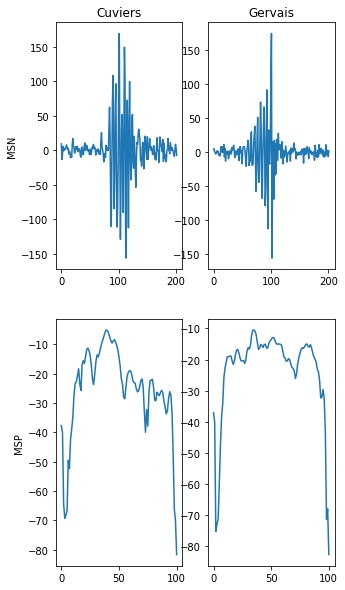

In [11]:
msn_1 = data_psdf.iloc[0]["MSN"]

plt.figure(figsize=(5,10))

# Cuviers
plt.subplot(2, 2, 1)
plt.plot(data_psdf.iloc[0]["MSN"])
plt.title("Cuviers")
plt.ylabel("MSN")

plt.subplot(2,2,3)
plt.plot(data_psdf.iloc[0]["MSP"])
plt.ylabel("MSP")

# Gervais
plt.subplot(2,2,2)
plt.plot(df_gervais.iloc[0]["MSN"])
plt.title("Gervais")

plt.subplot(2,2,4)
plt.plot(df_gervais.iloc[0]["MSP"])

MSN raw ticks signals is hardly modelizable.

The power spectral density MSP will be used to build the model.

In [12]:
from pyspark.ml.functions import array_to_vector
# => sql df to use sparkML functions
data_sqldf = data_psdf.to_spark()

# Converts MSP column of array of numeric type into a column of pyspark.ml.linalg.DenseVector instances
data_sqldf = data_sqldf.withColumn("features", array_to_vector('MSP').alias('features'))

data_psdf = data_sqldf.to_pandas_on_spark()
data_psdf.head(3)

/home/zenbook/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
22/04/10 10:07:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:24 WARN TaskSetManager: Stage 37 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,MSN,MSP,rec_no,features
0,1,50.2422,"[9.3197, -13.5086, -6.1229, 5.5962, -0.8494, 1...","[-37.7052, -40.2157, -64.4694, -69.3526, -68.2...",01,"[-37.7052, -40.2157, -64.4694, -69.3526, -68.2..."
1,1,55.0377,"[-2.2228, 6.5712, -14.2926, 8.2005, -1.0006, 2...","[-34.7333, -37.8125, -76.5551, -63.8601, -63.2...",01,"[-34.7333, -37.8125, -76.5551, -63.8601, -63.2..."
2,1,44.9439,"[5.8497, 0.9312, -1.3678, -1.0723, -4.6082, 0....","[-39.6219, -42.9117, -70.0049, -80.345, -82.53...",01,"[-39.6219, -42.9117, -70.0049, -80.345, -82.53..."


## Dimensionality reduction

The size of the MSP parameter array is too big for modeling: 

In [13]:
array_size = len(data_psdf.iloc[0]["MSP"])
print(f"Size of MSP array: {array_size}")

/home/zenbook/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
22/04/10 10:07:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:25 WARN TaskSetManager: Stage 39 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partit

Size of MSP array: 101


PCA is selected because Linear Discriminant Analysis is not avaible on SparkML

### Searching for 90% explained variance

In [14]:
from pyspark.ml.feature import PCA

pca = PCA(k=40, inputCol="features", outputCol="pca_features")

model_pca_tuning = pca.fit(data_sqldf)


22/04/10 10:07:26 WARN TaskSetManager: Stage 42 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:26 WARN TaskSetManager: Stage 43 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:26 WARN TaskSetManager: Stage 44 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:27 WARN TaskSetManager: Stage 45 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:28 WARN TaskSetManager: Stage 46 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:29 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/04/10 10:07:29 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Explained variance:

Text(0, 0.5, 'Explained Variance')

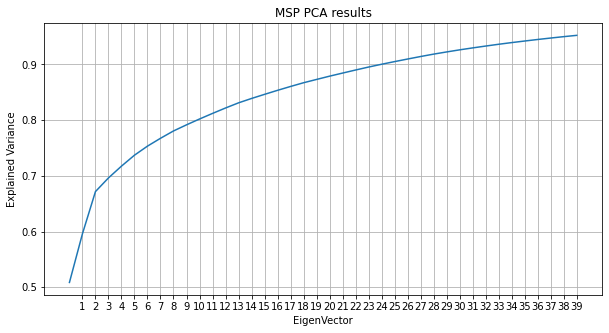

In [15]:
explain_var = model_pca_tuning.explainedVariance
explain_var.toArray().cumsum()

plt.figure(figsize=(10,5))

plt.plot(explain_var.toArray().cumsum())
plt.xticks(np.arange(1, 40, 1))
plt.grid()
plt.title("MSP PCA results")
plt.xlabel("EigenVector")
plt.ylabel("Explained Variance")

25 eigen-vectors explain 90% of the total data variance.

In [16]:
pca = PCA(k=25, inputCol="features", outputCol="pca_features")
model_pca = pca.fit(data_sqldf)

# project data set
data_proj_sqldf = model_pca.transform(data_sqldf)

22/04/10 10:07:30 WARN TaskSetManager: Stage 47 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:30 WARN TaskSetManager: Stage 48 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:30 WARN TaskSetManager: Stage 49 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:31 WARN TaskSetManager: Stage 50 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:31 WARN TaskSetManager: Stage 51 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


### format parameters

In [17]:
from pyspark.ml.functions import vector_to_array

data_sqldf = data_proj_sqldf.withColumn("eigen_vec", vector_to_array("pca_features").alias("eigen_vec")).select(
    ['label', 'peak_to_peak', 'eigen_vec'])

data_psdf = data_sqldf.to_pandas_on_spark()

data_psdf.head(3)

22/04/10 10:07:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:32 WARN TaskSetManager: Stage 52 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,eigen_vec
0,1,50.2422,"[223.42572149351003, 11.216241200228666, -142...."
1,1,55.0377,"[172.46215141896158, 11.390818317603765, -110...."
2,1,44.9439,"[238.112547022345, -4.903540332511209, -135.01..."


In [18]:
# Select 90% of variance => 25 EV
ev_size = 25

for count_ev in range(0, ev_size, 1):
    ev_name = "ev"+ str(count_ev+1)
    data_psdf[ev_name] = data_psdf["eigen_vec"].apply(lambda row: row[count_ev])

22/04/10 10:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:33 WARN TaskSetManager: Stage 54 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:33 WARN TaskSetManager: Stage 56 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:33 WARN WindowExec: No Partition Defined 

In [19]:
data_train_psdf = data_psdf.drop(columns=["eigen_vec"])
data_train_psdf.head(3)

22/04/10 10:07:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/04/10 10:07:41 WARN TaskSetManager: Stage 104 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,ev1,ev2,ev3,ev4,ev5,ev6,ev7,ev8,ev9,ev10,ev11,ev12,ev13,ev14,ev15,ev16,ev17,ev18,ev19,ev20,ev21,ev22,ev23,ev24,ev25
0,1,50.2422,223.425721,11.216241,-142.919313,-10.643589,-67.870365,-22.164351,14.075186,-53.040499,-10.701345,-64.191347,15.351938,35.650416,4.988684,-18.596385,6.600400,-24.470522,-3.348194,27.701095,-39.080991,19.638485,8.857874,-11.699886,24.590048,-27.468637,7.956810
1,1,55.0377,172.462151,11.390818,-110.020198,-16.789943,-68.291099,-28.519547,5.647416,-40.769006,-18.914926,-45.050700,18.295805,13.541150,-35.630924,-16.473065,7.116207,-34.314520,-9.295138,31.175521,-51.105404,30.071326,24.480734,-28.327592,33.783319,-21.635972,5.724563
2,1,44.9439,238.112547,-4.903540,-135.016914,-7.175954,-79.354488,-31.524763,26.780210,-59.315741,-4.163783,-53.704596,14.962801,13.171434,-10.862153,-15.996552,7.598023,-26.597926,-6.279655,33.621117,-41.740004,39.648072,22.440785,-14.997608,33.366311,-15.496912,-6.779416


## XGBoost Trees

The XGBoost model is a series of trees (like a random forest).

But XGBoost trees are built based on the latest tree result. Parallelization is worthless.

In [20]:

df_data = data_psdf.to_pandas()
df_data.head(5)

22/04/10 10:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/10 10:07:41 WARN TaskSetManager: Stage 106 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/10 10:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,label,peak_to_peak,eigen_vec,ev1,ev2,ev3,ev4,ev5,ev6,ev7,...,ev16,ev17,ev18,ev19,ev20,ev21,ev22,ev23,ev24,ev25
0,1,50.2422,"[223.42572149351003, 11.216241200228666, -142....",223.425721,11.216241,-142.919313,-10.643589,-67.870365,-22.164351,14.075186,...,-24.470522,-3.348194,27.701095,-39.080991,19.638485,8.857874,-11.699886,24.590048,-27.468637,7.956810
1,1,55.0377,"[172.46215141896158, 11.390818317603765, -110....",172.462151,11.390818,-110.020198,-16.789943,-68.291099,-28.519547,5.647416,...,-34.314520,-9.295138,31.175521,-51.105404,30.071326,24.480734,-28.327592,33.783319,-21.635972,5.724563
2,1,44.9439,"[238.112547022345, -4.903540332511209, -135.01...",238.112547,-4.903540,-135.016914,-7.175954,-79.354488,-31.524763,26.780210,...,-26.597926,-6.279655,33.621117,-41.740004,39.648072,22.440785,-14.997608,33.366311,-15.496912,-6.779416
3,1,72.7624,"[7.367667152476132, 3.1794577074233055, -115.7...",7.367667,3.179458,-115.774538,-5.080926,-65.201271,-13.907906,3.535402,...,-31.180537,-7.641818,10.503518,-37.524804,30.800294,19.907498,-22.203941,23.219282,-27.910632,1.647312
4,1,57.1313,"[183.58886406421874, -49.92791257876021, -158....",183.588864,-49.927913,-158.776951,13.082657,-83.158088,-20.904950,10.476100,...,-36.732194,4.692566,15.101350,-31.512943,33.321361,23.848768,-13.930197,30.287154,-15.742309,-0.552047


In [21]:
X_data = df_data[['peak_to_peak', 'ev1', 'ev2', 'ev3', 'ev4', 'ev5', 'ev6',
       'ev7', 'ev8', 'ev9', 'ev10', 'ev11', 'ev12', 'ev13', 'ev14', 'ev15',
       'ev16', 'ev17', 'ev18', 'ev19', 'ev20', 'ev21', 'ev22', 'ev23', 'ev24',
       'ev25']]
y_data = df_data["label"]

In [22]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7) # train: 70%
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5) # Validation: 15%, Testing: 15%
print(f"Size: Xtrain:{X_train.shape}, X_test:{X_test.shape}, X_val:{X_val.shape}")
# convert to XGB matrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

Size: Xtrain:(2922, 26), X_test:(626, 26), X_val:(627, 26)


### Point of comparaison

Dummy score on most frequent:

In [23]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f"Random classifier score: {dummy_clf.score(X_val, y_val).round(2)} ")

Random classifier score: 0.55 


## Tuning Hyperparameters 

In [24]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.08, 0.1, 0.3], # eta
              'max_depth': [2,3,4], # trees max deep
              'eval_metric' : ['logloss'], # smoother than error
              'n_estimators': [200], #number of trees
}

clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   verbose=0, refit=True)

bst = clf.fit(X_train, y_train)

In [25]:
clf.best_params_

{'eval_metric': 'logloss',
 'learning_rate': 0.08,
 'max_depth': 4,
 'n_estimators': 200,
 'nthread': 4,
 'objective': 'binary:logistic'}

Note: After a few shots, a learning rate of 0.3 is better.

In [26]:
param = {   'nthread':4, #when use hyperthread, xgboost may become slower
            'objective':'binary:logistic',
            'learning_rate': 0.3, # eta: shrinkage parameter
            'max_depth': 3, # depth of tree
            'eval_metric' : ['auc', 'logloss', 'error'], # last metric will be used for the best eval
            'nthread' : 4
}

evals_result = {}
print(param)
evallist = [(dtrain, 'train'), (dtest, 'test')]

{'nthread': 4, 'objective': 'binary:logistic', 'learning_rate': 0.3, 'max_depth': 3, 'eval_metric': ['auc', 'logloss', 'error']}


In [27]:
evals_result = {}
num_round = 500

bst = xgb.train(param, dtrain, num_round, evallist,verbose_eval=False, evals_result=evals_result)

500


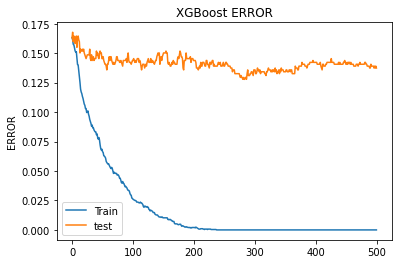

In [28]:
epochs = len(evals_result['train']['error'])
x_axis = range(0, epochs)
print(epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['error'], label='Train')
ax.plot(x_axis, evals_result['test']['error'], label='test')
ax.legend()
plt.ylabel('ERROR')
plt.title('XGBoost ERROR')
plt.show()

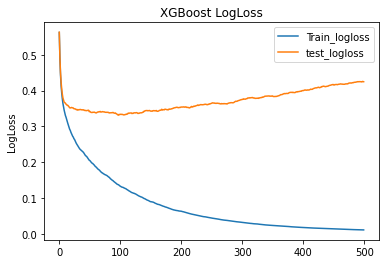

In [29]:
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['logloss'], label='Train_logloss')
ax.plot(x_axis, evals_result['test']['logloss'], label='test_logloss')
ax.legend()
plt.ylabel('LogLoss')
plt.title('XGBoost LogLoss')
plt.show()

### Tuning best number of trees

In [30]:
num_round=200
evals_result = {}
# early_stopping_rounds
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=100 ,verbose_eval=False, evals_result=evals_result)
print(f"Best error score: {bst.best_score} on round {bst.best_iteration}. ")

Best error score: 0.135783 on round 57. 


In [31]:
features_map = {'f0' : 'peak_to_peak',
                'f1' : 'Eigen Projection 1', 'f2' : 'Eigen Projection 2',
                'f3' : 'Eigen Projection 3', 'f4' : 'Eigen Projection 4',
                'f5' : 'Eigen Projection 5', 'f6' : 'Eigen Projection 6',
                'f7' : 'Eigen Projection 7', 'f8' : 'Eigen Projection 8',
                'f9' : 'Eigen Projection 9', 'f10' : 'Eigen Projection 10',
                'f11' : 'Eigen Projection 11', 'f12' : 'Eigen Projection 12',
                'f13' : 'Eigen Projection 13', 'f14' : 'Eigen Projection 14',
                'f15' : 'Eigen Projection 15', 'f16' : 'Eigen Projection 16',
                'f17' : 'Eigen Projection 17', 'f18' : 'Eigen Projection 18',
                'f19' : 'Eigen Projection 19', 'f20' : 'Eigen Projection 20',
                'f21' : 'Eigen Projection 21', 'f22' : 'Eigen Projection 22',
                'f23' : 'Eigen Projection 23', 'f24' : 'Eigen Projection 24',
                'f25' : 'Eigen Projection 25'
}

100 Iterations


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 360x360 with 0 Axes>

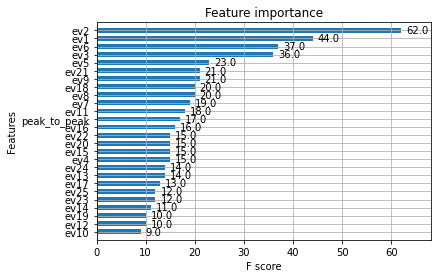

In [32]:
num_round = 80
evals_result = {}
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False, evals_result=evals_result)
print("100 Iterations")

plt.figure(figsize=(5,5))
xgb.plot_importance(bst, grid=True, height=(0.6))

### ROC

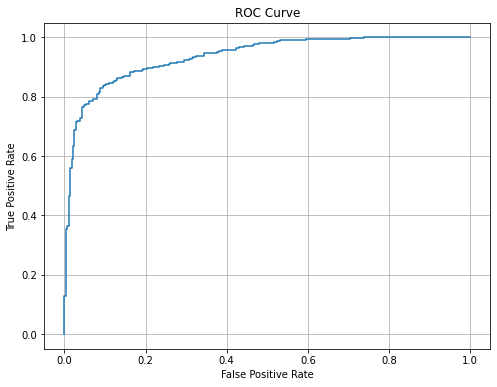

In [33]:

y_pred = bst.predict(dval, output_margin=True)

from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_val, y_pred)
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.grid()
plt.show()

The ROC is symmetric: Cuviers and Gervais are fairly predicted.

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

param = {'nthread':4,
              'learning_rate': 0.3,
              'max_depth': 3,
              'colsample_bytree' : 0.3,
              'n_estimators' : 80,
              'objective' :'binary:logistic',
              'eval_metric' : ['auc', 'logloss', 'error'],
                'use_label_encoder' : False # The use of label encoder in XGBClassifier is deprecated
}

bst_clf = xgb.XGBClassifier(**param)

bst_clf = bst_clf.fit(X_train, y_train)

y_val_pred = bst_clf.predict(X_val)

print("\nConfusion Matrix : ")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report : ")
print(classification_report(y_val, y_val_pred))


Confusion Matrix : 
[[241  43]
 [ 42 301]]

Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       284
           1       0.88      0.88      0.88       343

    accuracy                           0.86       627
   macro avg       0.86      0.86      0.86       627
weighted avg       0.86      0.86      0.86       627



## Conclusion

The echo-location clicks emitted by beaked whales are used to predict whale species (Curviers and Gervais). Precisely, the power spectral density (PSD) of echo-location clicks.

The large size of the PSD array is reduced by a factor of 4 using PCA projection using Spark.

THe XGBoost model is built and tuned using the XGB Python model and SKLearn.

Finally, the model predicts equitably the 2 species of whales with 85% precision and 85% recall.